In [1]:
using Flux, Statistics
using Flux: crossentropy, throttle, logitcrossentropy
using Base.Iterators: repeated, partition, flatten
using DelimitedFiles
using LinearAlgebra
using RDatasets
using GLM
using BSON: @save, @load
using Random
using Base.Threads 
using Plots

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/jupyter-nrmeskell/.julia/packages/CUDA/mVgLI/src/initialization.jl:42


In [2]:
function getEdepGateBarA0(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle = lpad(angle,3,"0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67, 2], (8,8))))
end

getEdepGateBarA0 (generic function with 1 method)

In [3]:
#getEdepGateBarA0(1, 0)

In [4]:
function getEdepGateBarA90(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle90 = lpad(angle+90, 3, "0")
    fileName90 = filter(x->occursin(string("A", angle90), x), readdir(folder))[number]
    filePath90 = string(folder, fileName90)
    return return Int.(round.(reshape(readdlm(filePath90)[4:67,2], (8,8))))
end

getEdepGateBarA90 (generic function with 1 method)

In [5]:
#getEdepGateBarA90(1, 40)

In [6]:
function getEdepGateGrid(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    angle = lpad(angle, 3, "0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(readdlm(filePath)[4:515,2]))
end

getEdepGateGrid (generic function with 1 method)

In [7]:
#getEdepGateGrid(1, 45)

dosimeter/gate_data/bars/W05__H05__A000_bars_extracted.txt

In [8]:
function getEdepOhioBarA0(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R...txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA0 (generic function with 1 method)

In [9]:
#getEdepOhioBarA0(1)

In [10]:
function getEdepOhioBarA90(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R.._r.txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA90 (generic function with 1 method)

In [11]:
#getEdepOhioBarA90(1)

In [12]:
function normalize(inputArray)
    min = minimum(inputArray)
    inputArray = (inputArray.-(min))
    max = maximum(inputArray)/1023
    inputArray = (inputArray./max).+1
    return Int.(round.(inputArray))
end

normalize (generic function with 1 method)

In [13]:
#normalize(getEdepOhioBarA90(1))

In [14]:
#normalize(getEdepOhioBarA0(1))

In [15]:
function makeTrainingData()
    numRuns = 18
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1] - 100
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*numRuns)
    
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, :, 1, (i-1)*numRuns + r] = getEdepGateBarA0(i,  (r-1)*15)
            trainingArray[:, :, 2, (i-1)*numRuns + r] = getEdepGateBarA90(i,  (r-1)*15)
        end
    end
    
    return trainingArray
end

makeTrainingData (generic function with 1 method)

In [16]:
size(filter(x->occursin("E02__W05__H05", x), readdir("/home/jupyter-nrmeskell/dosimeter/gate_data/bars/")))[1]

24

In [17]:
size(filter(x->occursin("A000", x), readdir("/home/jupyter-nrmeskell/dosimeter/gate_data/bars/")))[1]

500

In [18]:
function makeValidationData()
    numRuns = 18
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    #trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    start = size(filter(x->occursin("A000", x), readdir(folder)))[1] - 100
    trainingSize = 100
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, :, 1, (i-1)*numRuns + r] = getEdepGateBarA0(i + start, (r-1)*15)
            trainingArray[:, :, 2, (i-1)*numRuns + r] = getEdepGateBarA90(i + start, (r-1)*15)
        end
    end
    return trainingArray
end

makeValidationData (generic function with 1 method)

In [19]:
#makeValidationData()

In [20]:
function makeTargetData()
    numRuns = 18
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1] - 100
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, (i-1)*numRuns + r] = getEdepGateGrid(i, (r-1)*15)
        end
    end
    return trainingArray
end

makeTargetData (generic function with 1 method)

In [21]:
#makeTargetData()

In [22]:
function makeValTargetData()
    numRuns = 18
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    start = size(filter(x->occursin("A000", x), readdir(folder)))[1] - 100
    trainingSize = 100
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*numRuns)
    #trainingSize = 100
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, (i-1)*numRuns + r] = getEdepGateGrid(i + start, (r-1)*15)
        end
    end
    return trainingArray
end

makeValTargetData (generic function with 1 method)

In [23]:
#makeValTargetData()

In [24]:
function makeInputData()
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    trainingSize = size(filter(x->occursin("_r.txt", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize)
    
    for i = 1:trainingSize
        trainingArray[:,:,1,i] = getEdepOhioBarA0(i)
        trainingArray[:,:,2,i] = getEdepOhioBarA90(i)
    end
    return trainingArray
end

makeInputData (generic function with 1 method)

In [25]:
#makeInputData()

In [26]:
trainingArray = Float32.(makeTrainingData())

8×8×2×7200 Array{Float32, 4}:
[:, :, 1, 1] =
 2.0  3.0   2.0  379.0  382.0   3.0  0.0  0.0
 0.0  2.0   2.0  304.0  404.0   2.0  2.0  0.0
 2.0  2.0   5.0  320.0  341.0   2.0  0.0  0.0
 2.0  1.0  23.0  399.0  375.0   3.0  4.0  0.0
 1.0  3.0   6.0  369.0  484.0   7.0  1.0  0.0
 0.0  2.0   2.0  374.0  469.0   4.0  1.0  2.0
 1.0  1.0   3.0  253.0  421.0   4.0  1.0  2.0
 1.0  0.0  29.0  156.0  193.0  20.0  3.0  1.0

[:, :, 2, 1] =
 1.0   3.0  20.0  462.0  306.0   2.0  1.0  1.0
 0.0   5.0  21.0  517.0  295.0   2.0  1.0  1.0
 0.0   1.0   2.0  557.0  406.0   2.0  1.0  0.0
 1.0   0.0   5.0  497.0  517.0   2.0  4.0  1.0
 0.0   0.0  11.0  421.0  390.0   4.0  2.0  2.0
 1.0   2.0  35.0  334.0  254.0   2.0  3.0  0.0
 1.0   0.0  27.0  339.0  417.0  11.0  0.0  1.0
 1.0  31.0   1.0  218.0  239.0  20.0  0.0  1.0

[:, :, 1, 2] =
  0.0  4.0  13.0  300.0  300.0   6.0  2.0  2.0
  1.0  1.0   4.0  429.0  344.0   5.0  1.0  0.0
  2.0  3.0   3.0  398.0  331.0  20.0  4.0  2.0
  2.0  2.0  35.0  536.0  321.0   2.0  

In [27]:
targetArray = Float32.(makeTargetData())

512×7200 Matrix{Float32}:
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  …  0.0   0.0   0.0  0.0  0.0  2.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0   0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0   0.0   0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0   2.0   1.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0   5.0   0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0   5.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  0.0     0.0   3.0   0.0  0.0  0.0  0.0  1.0
 0.0  0.0  1.0  0.0  2.0  0.0  0.0     0.0   0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0   0.0   0.0  1.0  0.0  4.0  6.0
 0.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0   0.0   0.0  0.0  0.0  2.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0   0.0   0.0  0.0  4.0  5.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0     2.0   0.0   3.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     4.0  14.0   0.0  0.0  0.0  0.0  0.0

In [28]:
validationArray = Float32.(makeValidationData())

8×8×2×1800 Array{Float32, 4}:
[:, :, 1, 1] =
  0.0  45.0  260.0  1823.0  1473.0  195.0  36.0   0.0
 19.0  43.0  244.0  1687.0  1596.0  263.0  14.0   1.0
  0.0   5.0  107.0  1312.0  1586.0  194.0   2.0   0.0
 21.0  34.0   86.0  1109.0  1340.0  115.0   3.0   0.0
  0.0   1.0   75.0   940.0  1176.0  144.0  25.0   0.0
  0.0   1.0   18.0   705.0   846.0   39.0   0.0   0.0
  0.0  17.0   56.0   495.0   608.0   18.0   0.0  11.0
  0.0   2.0   13.0   159.0   196.0    1.0   1.0  10.0

[:, :, 2, 1] =
 2.0  26.0  236.0  1561.0  1461.0  222.0  62.0  15.0
 2.0  16.0  305.0  1589.0  1524.0  220.0  35.0   9.0
 0.0  42.0  178.0  1527.0  1535.0  213.0  20.0   1.0
 0.0  12.0   90.0  1212.0  1257.0  105.0  11.0   2.0
 0.0  26.0   55.0   976.0   988.0  136.0   8.0   0.0
 0.0   5.0   39.0   729.0   809.0   90.0   6.0   0.0
 0.0   3.0   31.0   509.0   518.0   35.0   8.0   3.0
 0.0   6.0   28.0   175.0   181.0    0.0  10.0   0.0

[:, :, 1, 2] =
  1.0  11.0  127.0  1644.0  1440.0  221.0  31.0  13.0
  0.0   6.0  

In [29]:
validationTargetArray = Float32.(makeValTargetData())

512×1800 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  …  0.0  0.0  2.0  0.0  0.0  0.0  20.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0     0.0  0.0  0.0  4.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0   1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0   0.0
 0.0  1.0  0.0  0.0  0.0   0.0  0.0     0.0  0.0  1.0  0.0  0.0  0.0  10.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0     2.0  0.0  2.0  5.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  1.0   0.0  0.0  …  0.0  1.0  3.0  5.0  0.0  0.0   0.0
 1.0  0.0  0.0  0.0  0.0   0.0  0.0     0.0  0.0  2.0  1.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0   0.0  0.0     0.0  0.0  1.0  1.0  0.0  0.0   9.0

In [30]:
inputArray = Float32.(makeInputData())

8×8×2×21 Array{Float32, 4}:
[:, :, 1, 1] =
 38484.0  42128.0  52850.0  126117.0  208366.0  54216.0  42413.0  38391.0
 39382.0  44555.0  47446.0  118228.0  285328.0  61556.0  41870.0  39128.0
 36595.0  39956.0  55851.0  189571.0  294911.0  57231.0  42411.0  38908.0
 38021.0  43502.0  45917.0  122588.0  483994.0  71271.0  40778.0  39157.0
 40115.0  46611.0  55757.0  176140.0  345909.0  74524.0  42913.0  39929.0
 39228.0  38664.0  58439.0  162217.0  244550.0  68536.0  43572.0  39139.0
 37466.0  37933.0  56898.0  131986.0  361086.0  60613.0  48624.0  37953.0
 35604.0  38155.0  43116.0   84692.0  184161.0  70698.0  43053.0  37902.0

[:, :, 2, 1] =
 19404.0  22059.0  44432.0  101296.0   77978.0  36257.0  21430.0  19332.0
 20006.0  24228.0  42568.0   87020.0  105097.0  53825.0  21343.0  20054.0
 17905.0  20826.0  56275.0  160868.0  105372.0  47073.0  21694.0  19664.0
 19379.0  23974.0  36643.0   91733.0  144345.0  65212.0  20635.0  20134.0
 20977.0  26756.0  56546.0  140444.0  126791.0  68834

In [31]:
function plotResults(m)
    image = rand((1: size(trainingArray)[2]))
    print(image)
    display(heatmap(reshape(Int64.(round.(m(validationArray)))[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Prediction"))
    display(heatmap(reshape(validationTargetArray[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Target"))
    display(heatmap(reshape(Int64.(round.(m(inputArray)))[:,1], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="Ohio Data Prediction"))
end

plotResults (generic function with 1 method)

In [32]:
m = Chain(Conv((2,2), 2=>8, pad=(1,1), relu),
    Conv((2,2), 8=>16, pad=(1,1), relu),
    Dropout(0.05),

    x -> reshape(x, :, size(x,4)), 

    Dense(1600, 900),
    Dense(900, 8*8*8),
    x -> abs.(x))

Chain(Conv((2, 2), 2=>8, relu), Conv((2, 2), 8=>16, relu), Dropout(0.05), #27, Dense(1600, 900), Dense(900, 512), #28)

In [33]:
loss(x, y) = mean((m(x)-y).^2)
opt = ADAM()
dataset = (repeated((trainingArray, targetArray), 50))
evalcb = () -> @show (loss(trainingArray, targetArray)) 

CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
print("Training R2: ", CurrentR2, '\n')
CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
print("Validation R2: ", CurrentVR2, '\n')

Training R2: 0.003988867468028956
Validation R2: 0.007987815938048981


loss(trainingArray, targetArray) = 7364.416f0
loss(trainingArray, targetArray) = 3162.9634f0
loss(trainingArray, targetArray) = 2330.28f0
loss(trainingArray, targetArray) = 1739.785f0
loss(trainingArray, targetArray) = 1496.0328f0
loss(trainingArray, targetArray) = 1365.387f0
loss(trainingArray, targetArray) = 1273.2009f0
loss(trainingArray, targetArray) = 1220.4181f0
loss(trainingArray, targetArray) = 1187.9153f0
loss(trainingArray, targetArray) = 1158.0011f0
loss(trainingArray, targetArray) = 1137.1082f0
loss(trainingArray, targetArray) = 1124.2766f0
loss(trainingArray, targetArray) = 1110.4772f0
Training R2: 0.898318376549002
Validation R2: 0.9732425123984221

	

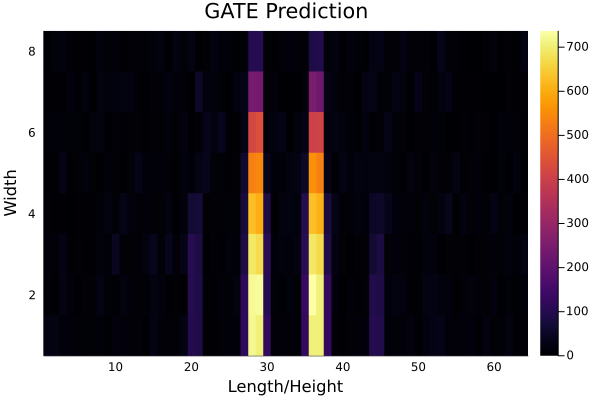

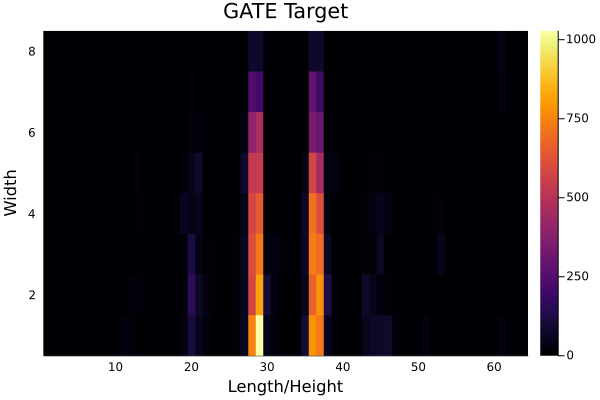

3

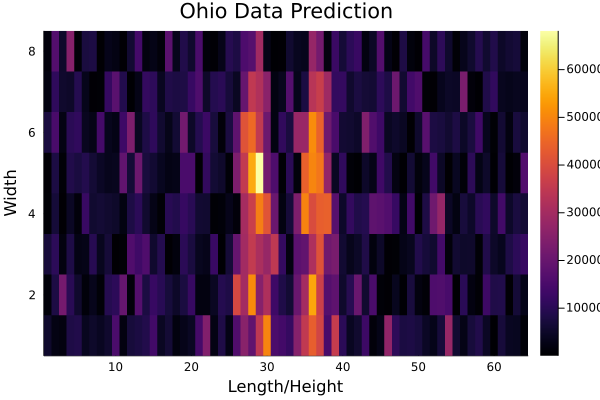

loss(trainingArray, targetArray) = 1107.1818f0
loss(trainingArray, targetArray) = 1095.4049f0
loss(trainingArray, targetArray) = 1086.6519f0
loss(trainingArray, targetArray) = 1079.4266f0
loss(trainingArray, targetArray) = 1072.2423f0
loss(trainingArray, targetArray) = 1065.8481f0
loss(trainingArray, targetArray) = 1060.3259f0


In [ ]:
for i = 1:10
    Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 5))
    CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
    print("Training R2: ", CurrentR2, '\n')
    CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
    print("Validation R2: ", CurrentVR2, '\n')
    print("\n\t")
    plotResults(m)
end

In [ ]:
function writeOutput(m)
    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    readSize = size(readArray)[1]
    
    path = "/home/jupyter-nrmeskell/dosimeter/neural_nets/JuliaOutputs/OptimizedRuns"
    runNumber = lpad(size(readdir(path))[1], 3, "0")
    path = string(path, "/Run", runNumber, "R2-", lpad(Int(round(CurrentVR2, digits=3)*1000),3,"0"))
    mkdir(path)
    mkdir(string(path, "/fullSimulationOutputs"))
    mkdir(string(path, "/fullOhioOutputs"))
            
    for i = 1:size(validationTargetArray)[2]
        beamSize = filter(x->occursin(string("A000"), x), readdir(readPath))[div(100-1, div(size(validationTargetArray)[2],readSize))+1][1:8]

        writedlm(string(path,"/fullSimulationOutputs/ValidationTarget",lpad(i,3,"0"), "-", beamSize, ".txt"), reshape(validationTargetArray[:,i], (8*8,8)), " ")
        writedlm(string(path,"/fullSimulationOutputs/ValidationOutput",lpad(i,3,"0"), "-", beamSize, ".txt"), Int.(round.(reshape(m(validationArray)[:,i], (8*8,8)))), " ")
    end


    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    for i = 1:size(inputArray)[4]
        writedlm(string(path,"/fullOhioOutputs/OhioOutput",lpad(i,3,"0"),".txt"), Int.(round.(reshape(m(inputArray)[:,i], (8*8,8)))), " ")
    end
end

In [ ]:
writeOutput(m)